Importing Required Library

In [ ]:
!pip install statsmodels==0.13.5

import pandas as pd
import numpy as np
from pandas import datetime

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

from sklearn.metrics import mean_squared_error
from math import sqrt

# Set the default figure style
plt.style.use('./d4sci.mplstyle')

%matplotlib inline

<ipython-input-1-fd39038c3900>:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


Importing data from CSV file to a pandas dataframe

In [ ]:
raw_data=pd.read_csv('Call Center Dataa.csv')

In [ ]:
raw_data.head()

date        day  Incoming Calls  Answered Calls Answer Rate  \
0  11/1/2022  Wednesday         21700.0         20400.0      94.01%   
1  11/2/2022   Thursday         20000.0         18200.0      91.00%   
2  11/3/2022     Friday         21600.0         19800.0      91.67%   
3  11/4/2022   Saturday         15500.0         14500.0      93.55%   
4  11/5/2022     Sunday         19700.0          3700.0     100.00%   

   Abandoned Calls Answer Speed (AVG) Talk Duration (AVG) Waiting Time (AVG)  \
0           1300.0            0:00:17             0:02:14            0:02:45   
1           1800.0            0:00:20             0:02:22            0:06:55   
2           1800.0            0:00:18             0:02:38            0:03:50   
3           1000.0            0:00:15             0:02:29            0:03:12   
4          16000.0            0:00:03             0:02:06            0:00:35   

  Service Level (20 Seconds)  
0                     76.28%  
1                     72.73%  
2                     74.30%  
3                     79.61%  
4                     97.30%

Checking for missing Values

In [ ]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   date                        212 non-null    object 
 1   day                         212 non-null    object 
 2   Incoming Calls              207 non-null    float64
 3   Answered Calls              207 non-null    float64
 4   Answer Rate                 207 non-null    object 
 5   Abandoned Calls             207 non-null    float64
 6   Answer Speed (AVG)          207 non-null    object 
 7   Talk Duration (AVG)         207 non-null    object 
 8   Waiting Time (AVG)          207 non-null    object 
 9   Service Level (20 Seconds)  207 non-null    object 
dtypes: float64(3), object(7)
memory usage: 16.7+ KB


Data Imputation

In [ ]:
copy_raw_data=raw_data.loc[raw_data['Incoming Calls'].notna()].copy()
copy_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207 entries, 0 to 211
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   date                        207 non-null    object 
 1   day                         207 non-null    object 
 2   Incoming Calls              207 non-null    float64
 3   Answered Calls              207 non-null    float64
 4   Answer Rate                 207 non-null    object 
 5   Abandoned Calls             207 non-null    float64
 6   Answer Speed (AVG)          207 non-null    object 
 7   Talk Duration (AVG)         207 non-null    object 
 8   Waiting Time (AVG)          207 non-null    object 
 9   Service Level (20 Seconds)  207 non-null    object 
dtypes: float64(3), object(7)
memory usage: 17.8+ KB


In [ ]:
in_call_mean=copy_raw_data['Incoming Calls'].mean().round()
in_call_mean

19475.0

In [ ]:
new_df=raw_data[['date','Incoming Calls']]
new_df['date']=pd.to_datetime(new_df['date'])
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            212 non-null    datetime64[ns]
 1   Incoming Calls  207 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.4 KB


<ipython-input-7-b218a110d3c0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['date']=pd.to_datetime(new_df['date'])


In [ ]:
new_df.fillna(in_call_mean,inplace=True)
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            212 non-null    datetime64[ns]
 1   Incoming Calls  212 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.4 KB


<ipython-input-8-703c523e7856>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.fillna(in_call_mean,inplace=True)


Plot the Daily Incoming Calls

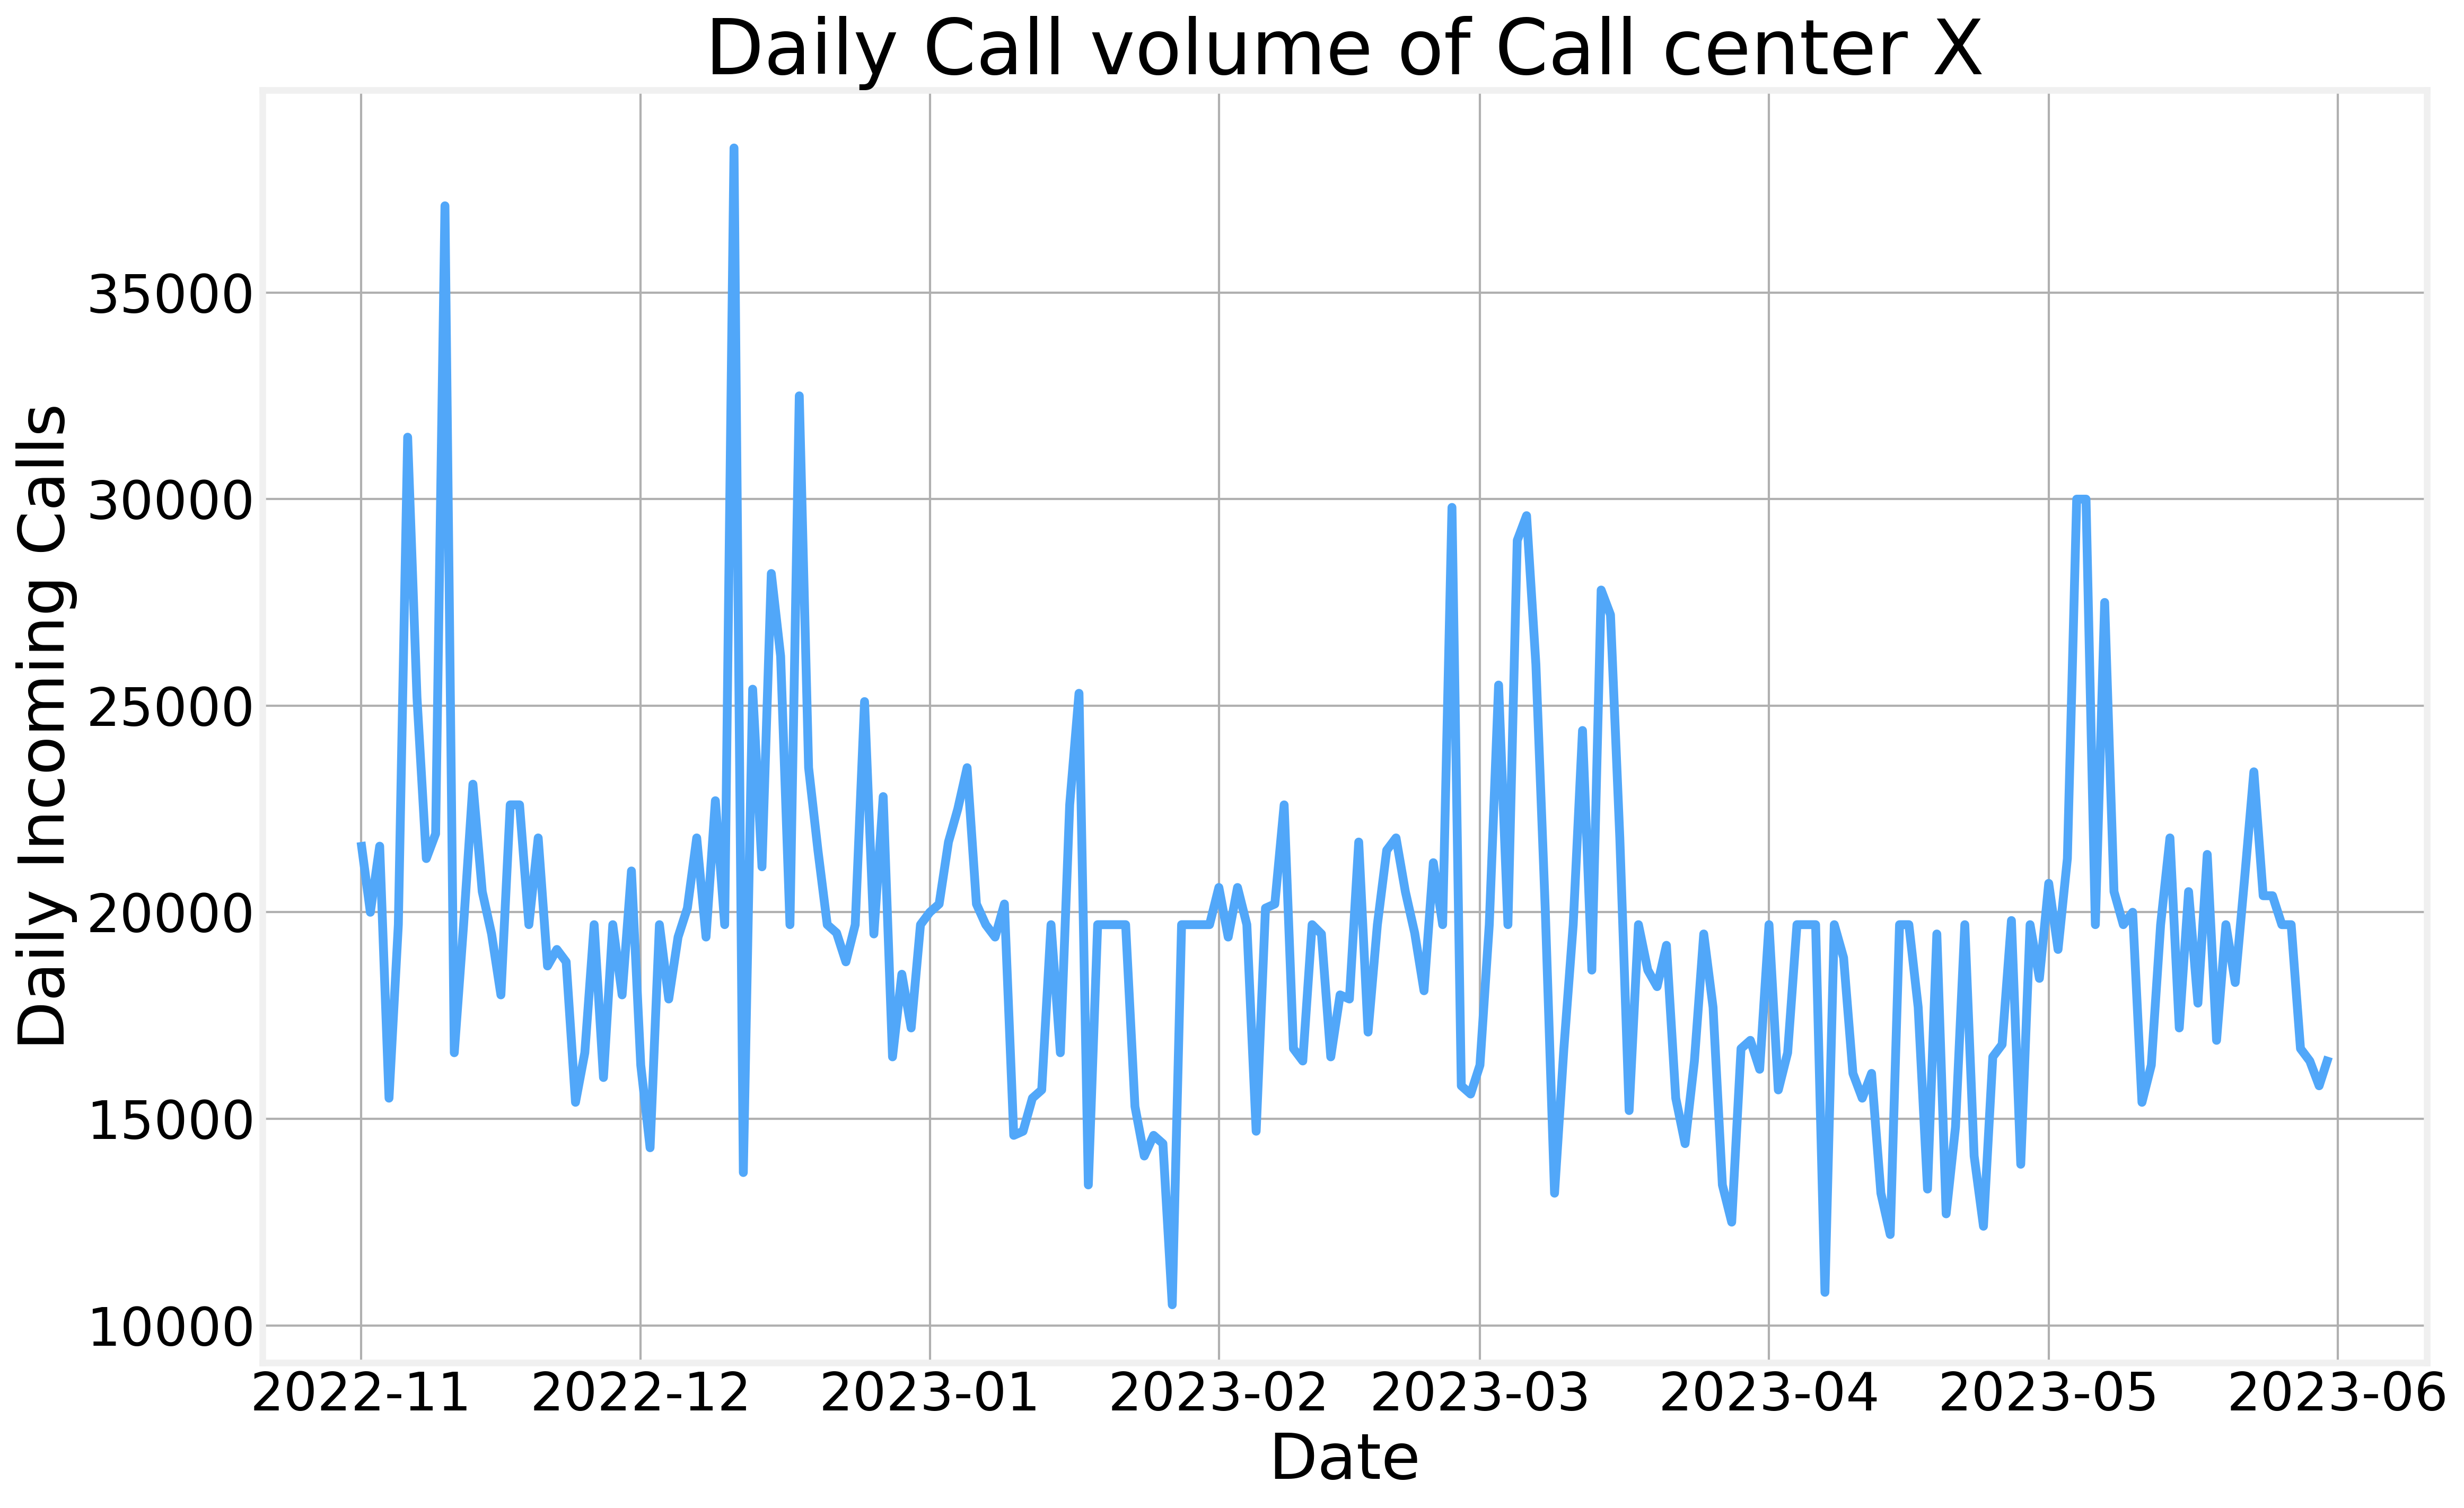

In [ ]:

fig, ax = plt.subplots(figsize=(16,10))

ax.plot(new_df['date'], new_df['Incoming Calls'],label='Daily Incoming Call')

ax.set(xlabel="Date", ylabel="Daily Incoming Calls",
       title="Daily Call volume of Call center X")


ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))

plt.show()

ARIMA Preparation

Converting the Dataframe to series

In [ ]:
new_df.set_index('date',inplace=True)
series=new_df.squeeze()
series

date
2022-11-01    21700.0
2022-11-02    20000.0
2022-11-03    21600.0
2022-11-04    15500.0
2022-11-05    19700.0
               ...   
2023-05-27    19700.0
2023-05-28    16700.0
2023-05-29    16400.0
2023-05-30    15800.0
2023-05-31    16500.0
Name: Incoming Calls, Length: 212, dtype: float64

In [ ]:
print (type(series))

<class 'pandas.core.series.Series'>


Split 80% of the data set contained in series into a set called train. The remaining 20% will be contained in a set called test.

In [ ]:
# making a copy of the series called temp
temp = series

# 80% of the data is for training
size = int(len(temp) * 0.80)

train, test = temp[0:size], temp[size:len(temp)]

 Plot a graph of train

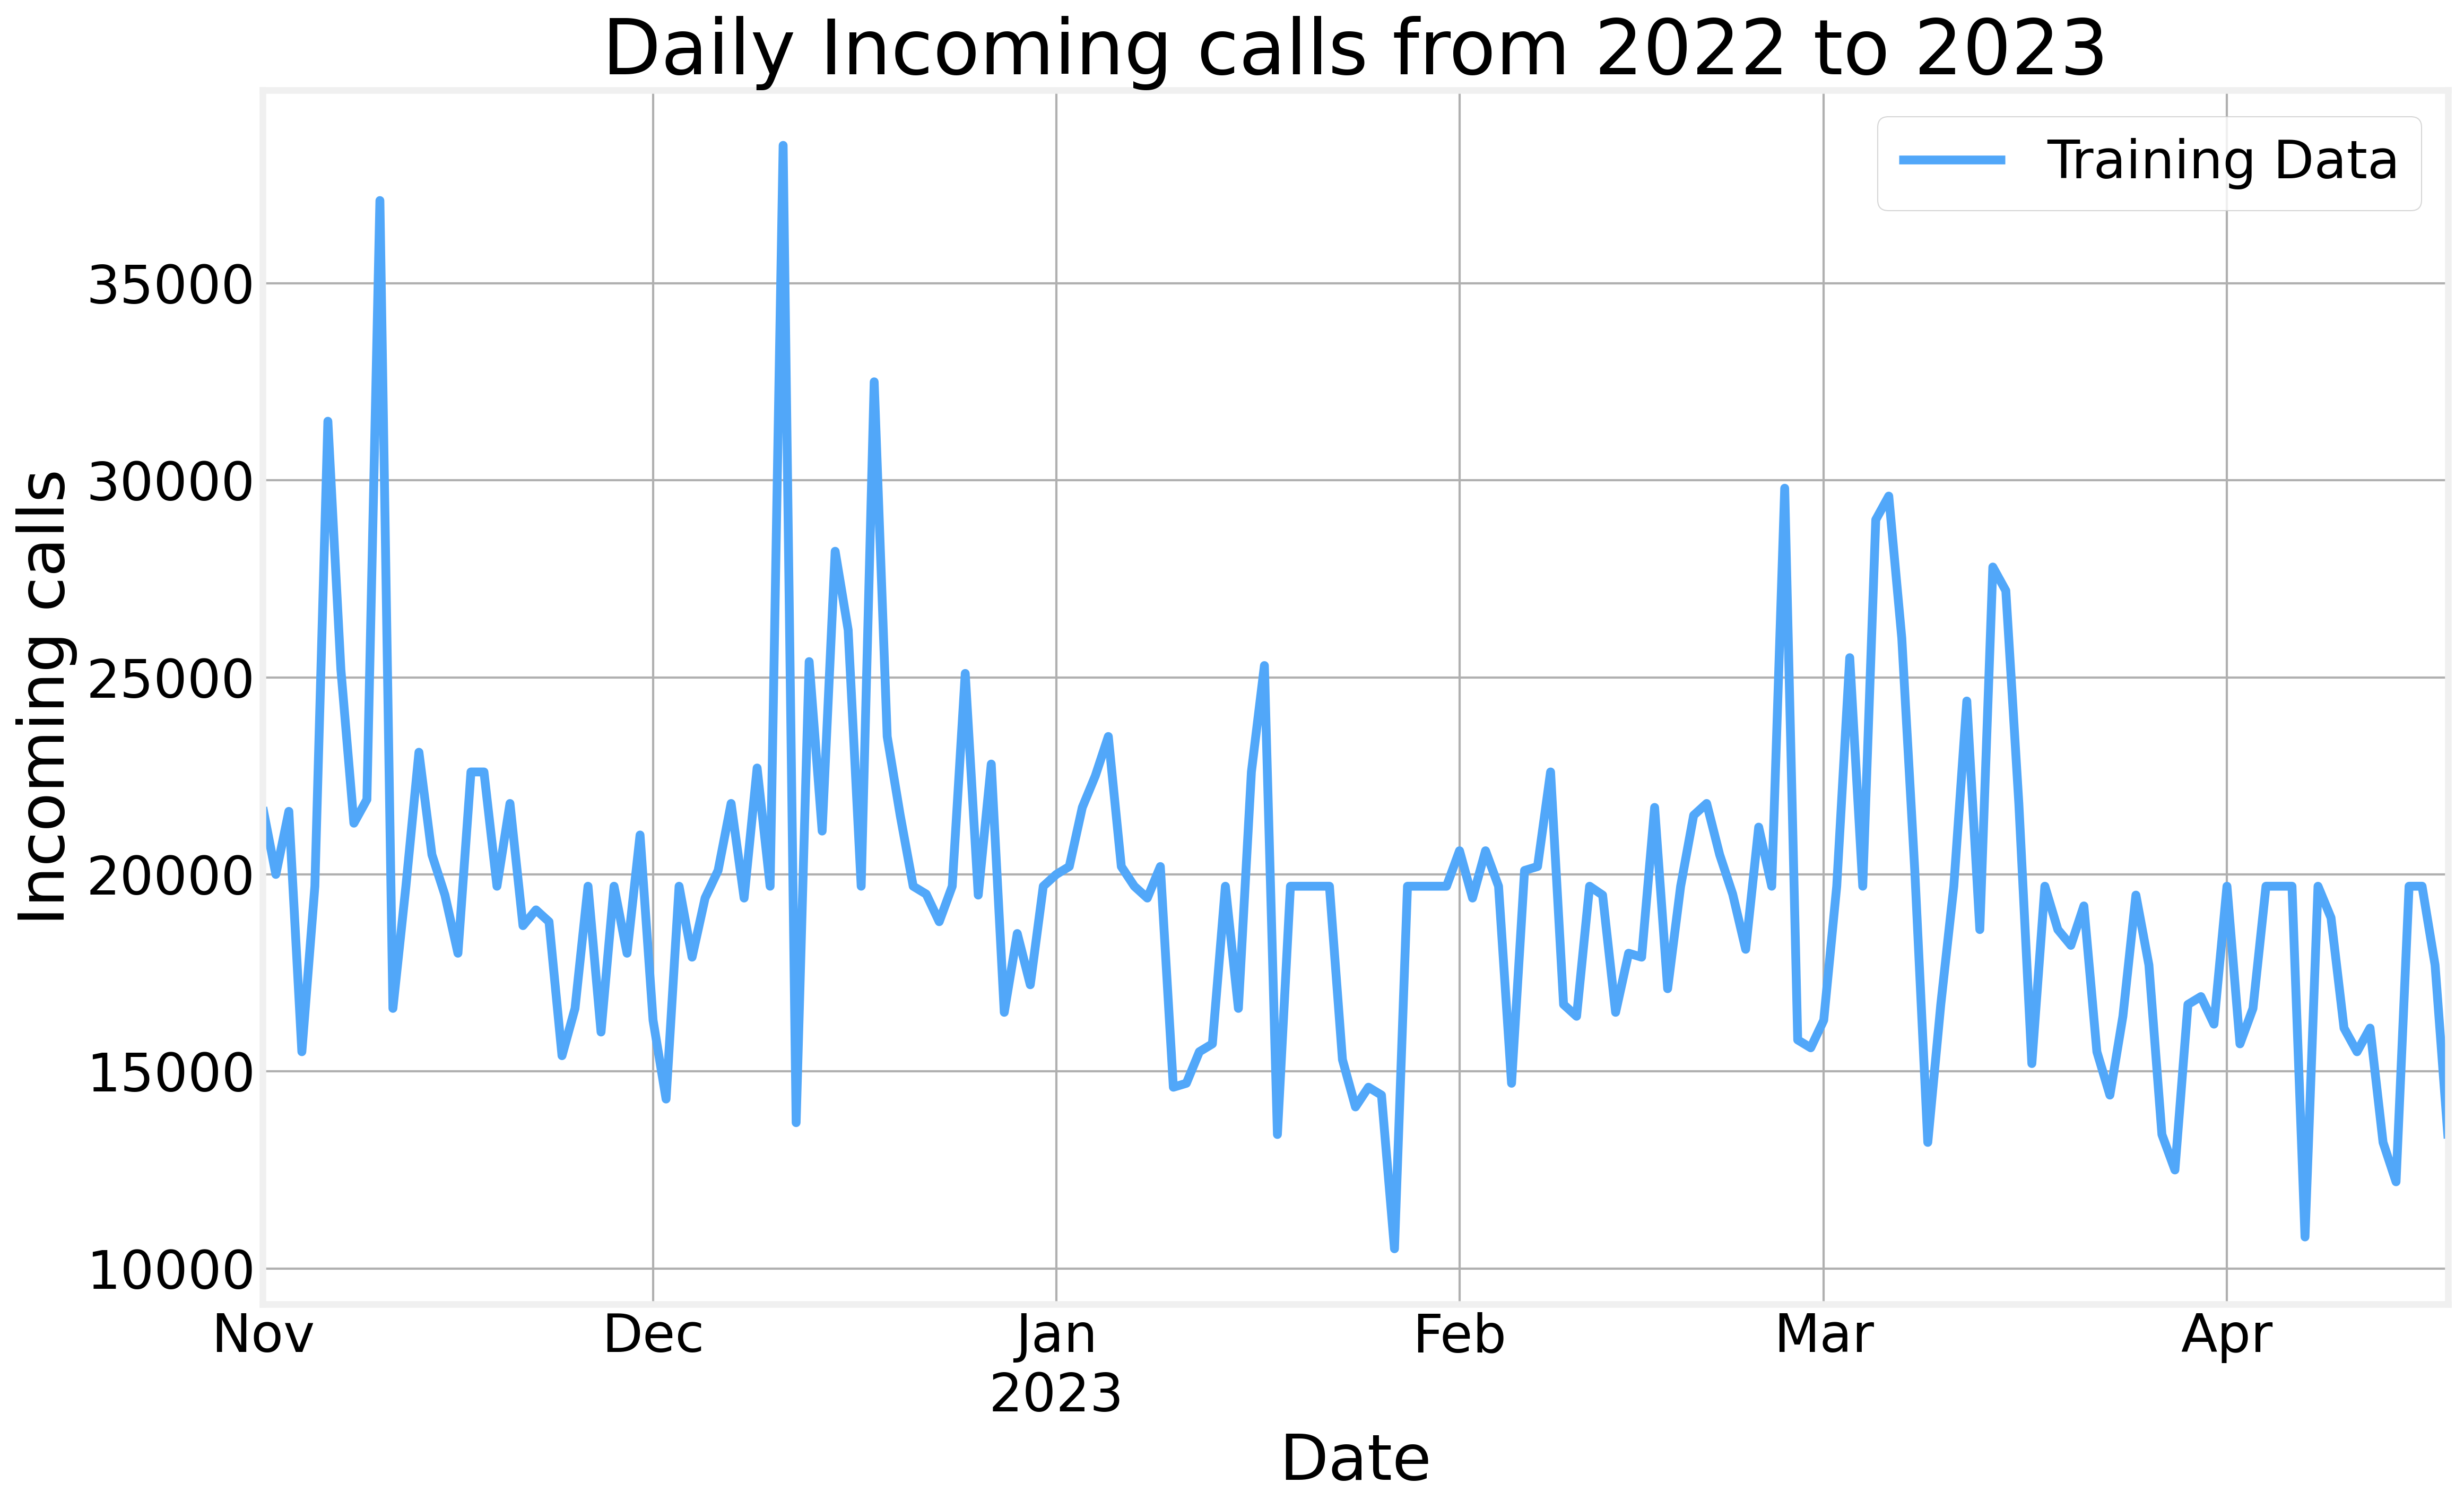

In [ ]:
plt.rcParams["figure.figsize"] = (16, 10)
train.plot(label='Training Data')
plt.title("Daily Incoming calls from 2022 to 2023")
plt.xlabel("Date")
plt.ylabel("Incoming calls")
plt.legend()
plt.show()

Calling the plot_acf method, sending train and lags=90

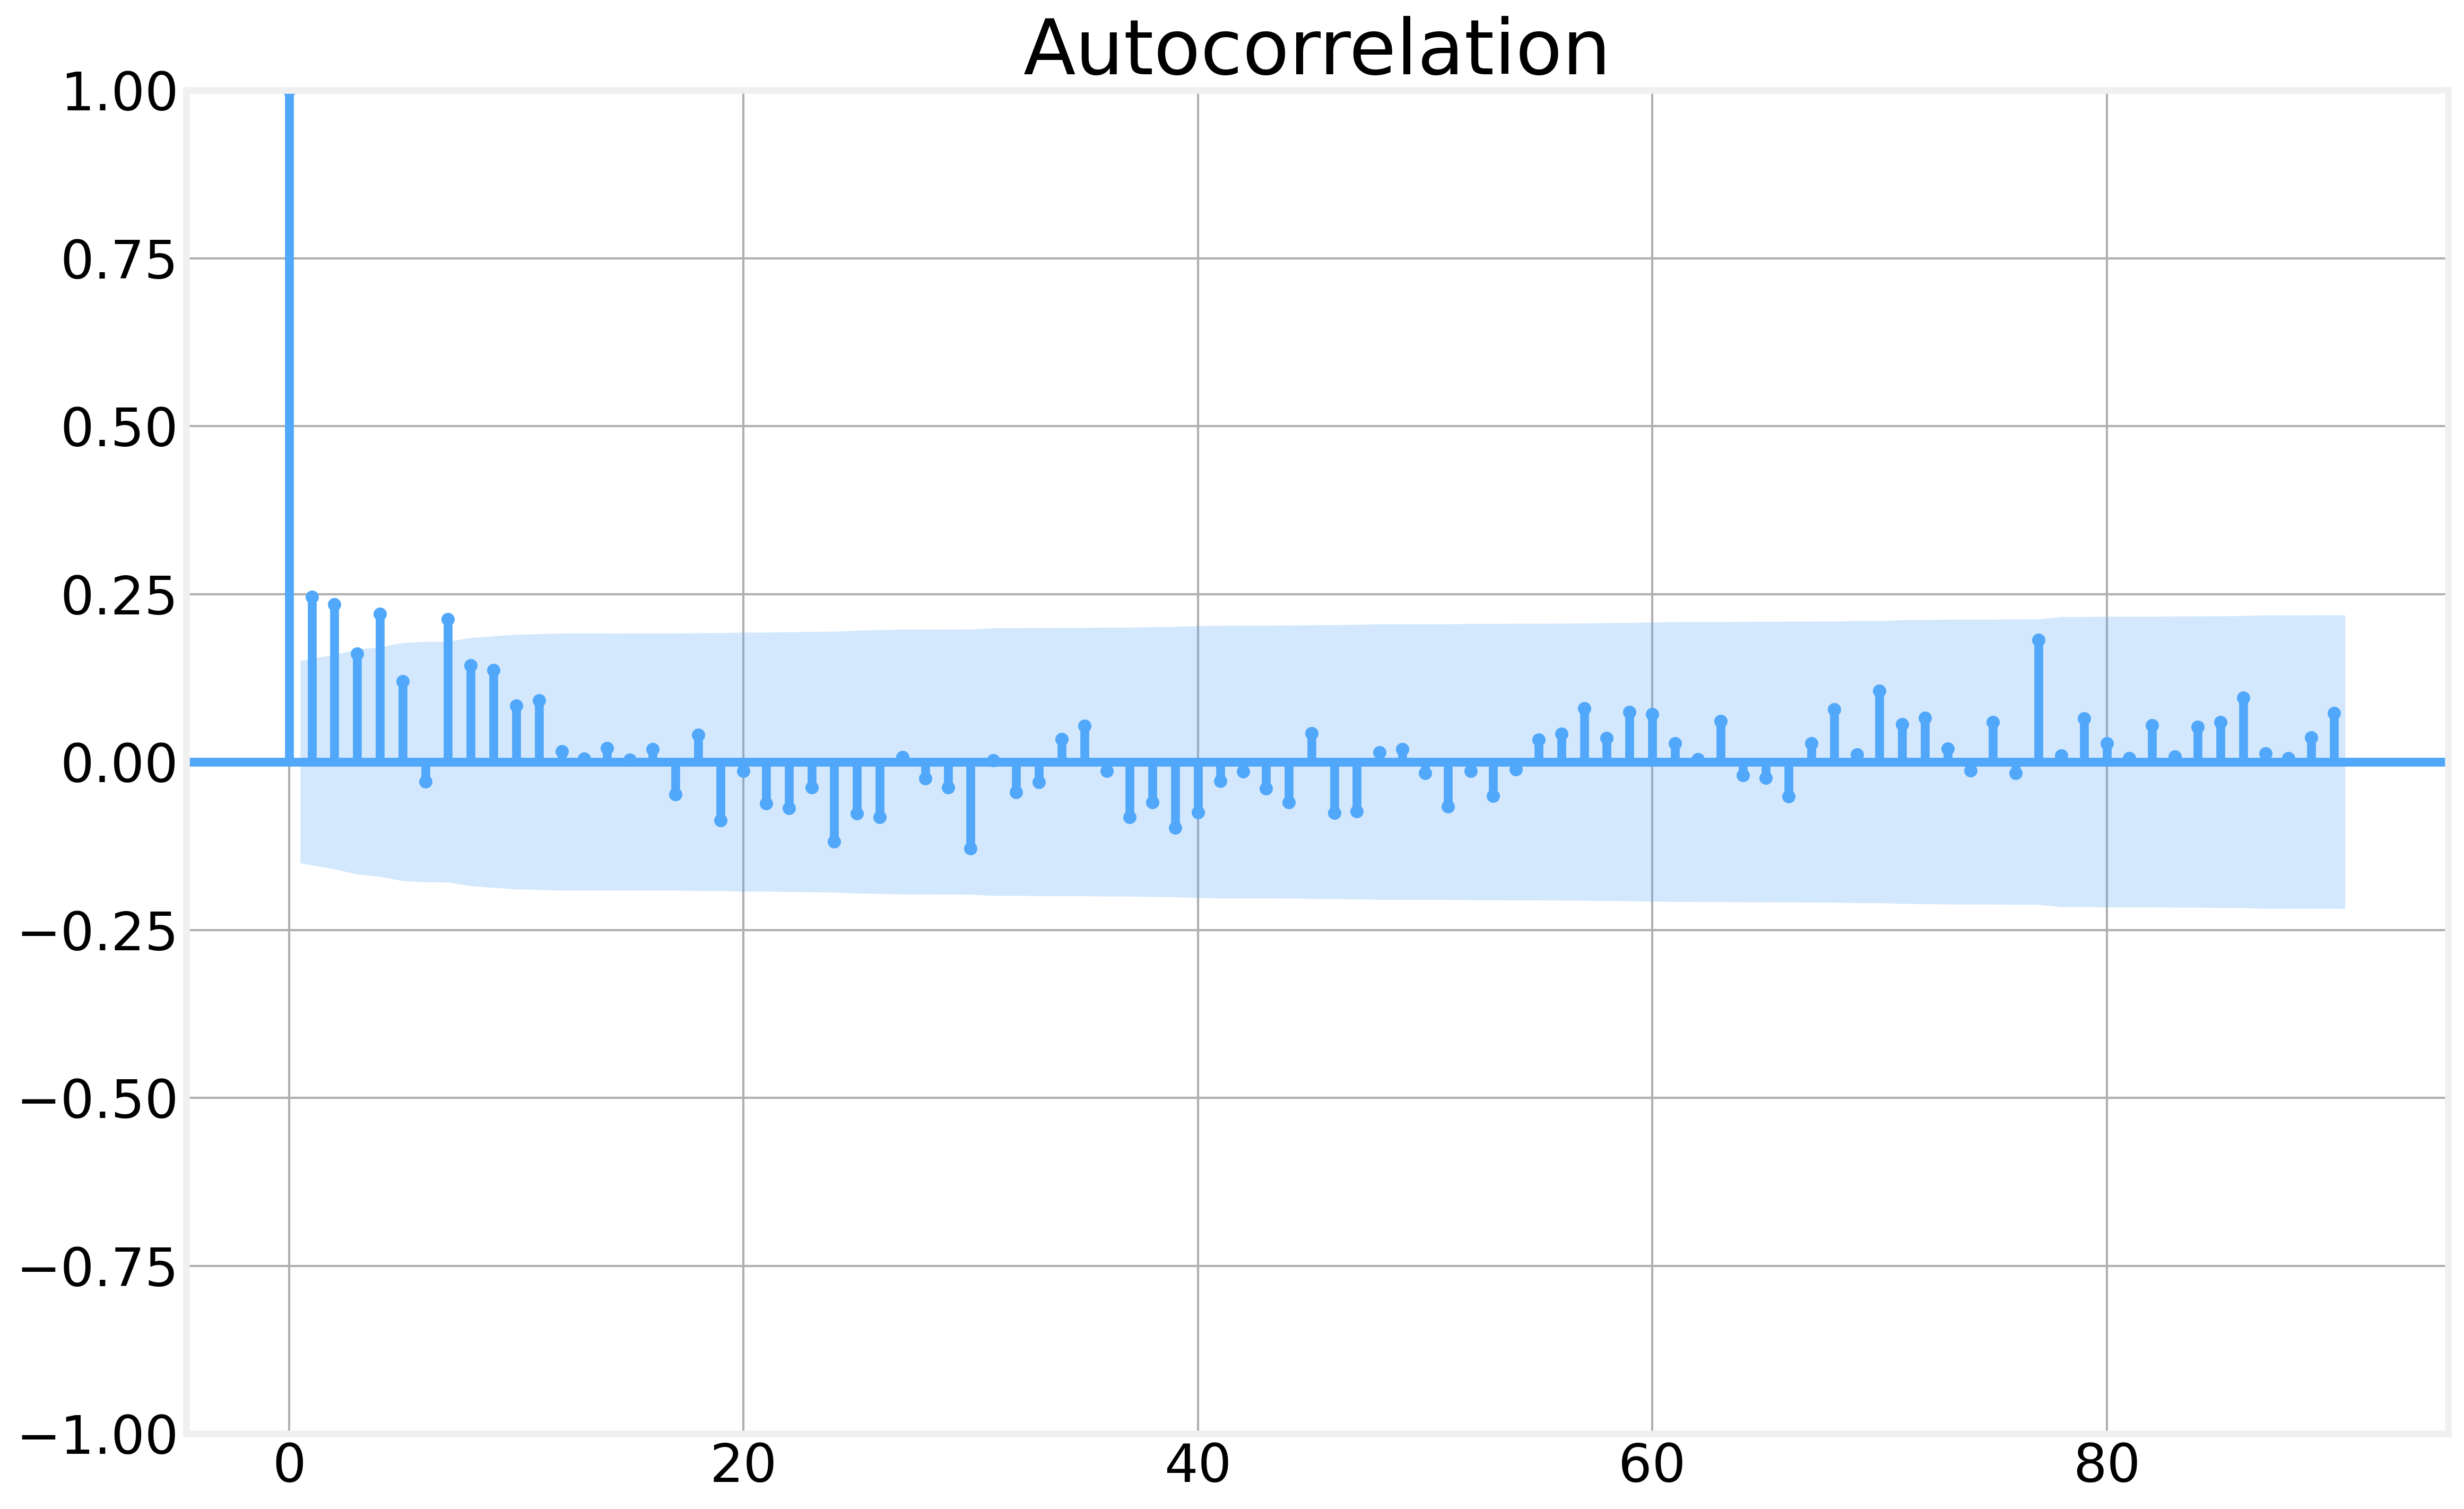

In [ ]:
plot_acf(train, lags=90);

Create another series called fd_series that is the first difference of train. Plot the train and fd_series to see the difference

In [ ]:
fd_series = train.diff(1).dropna()

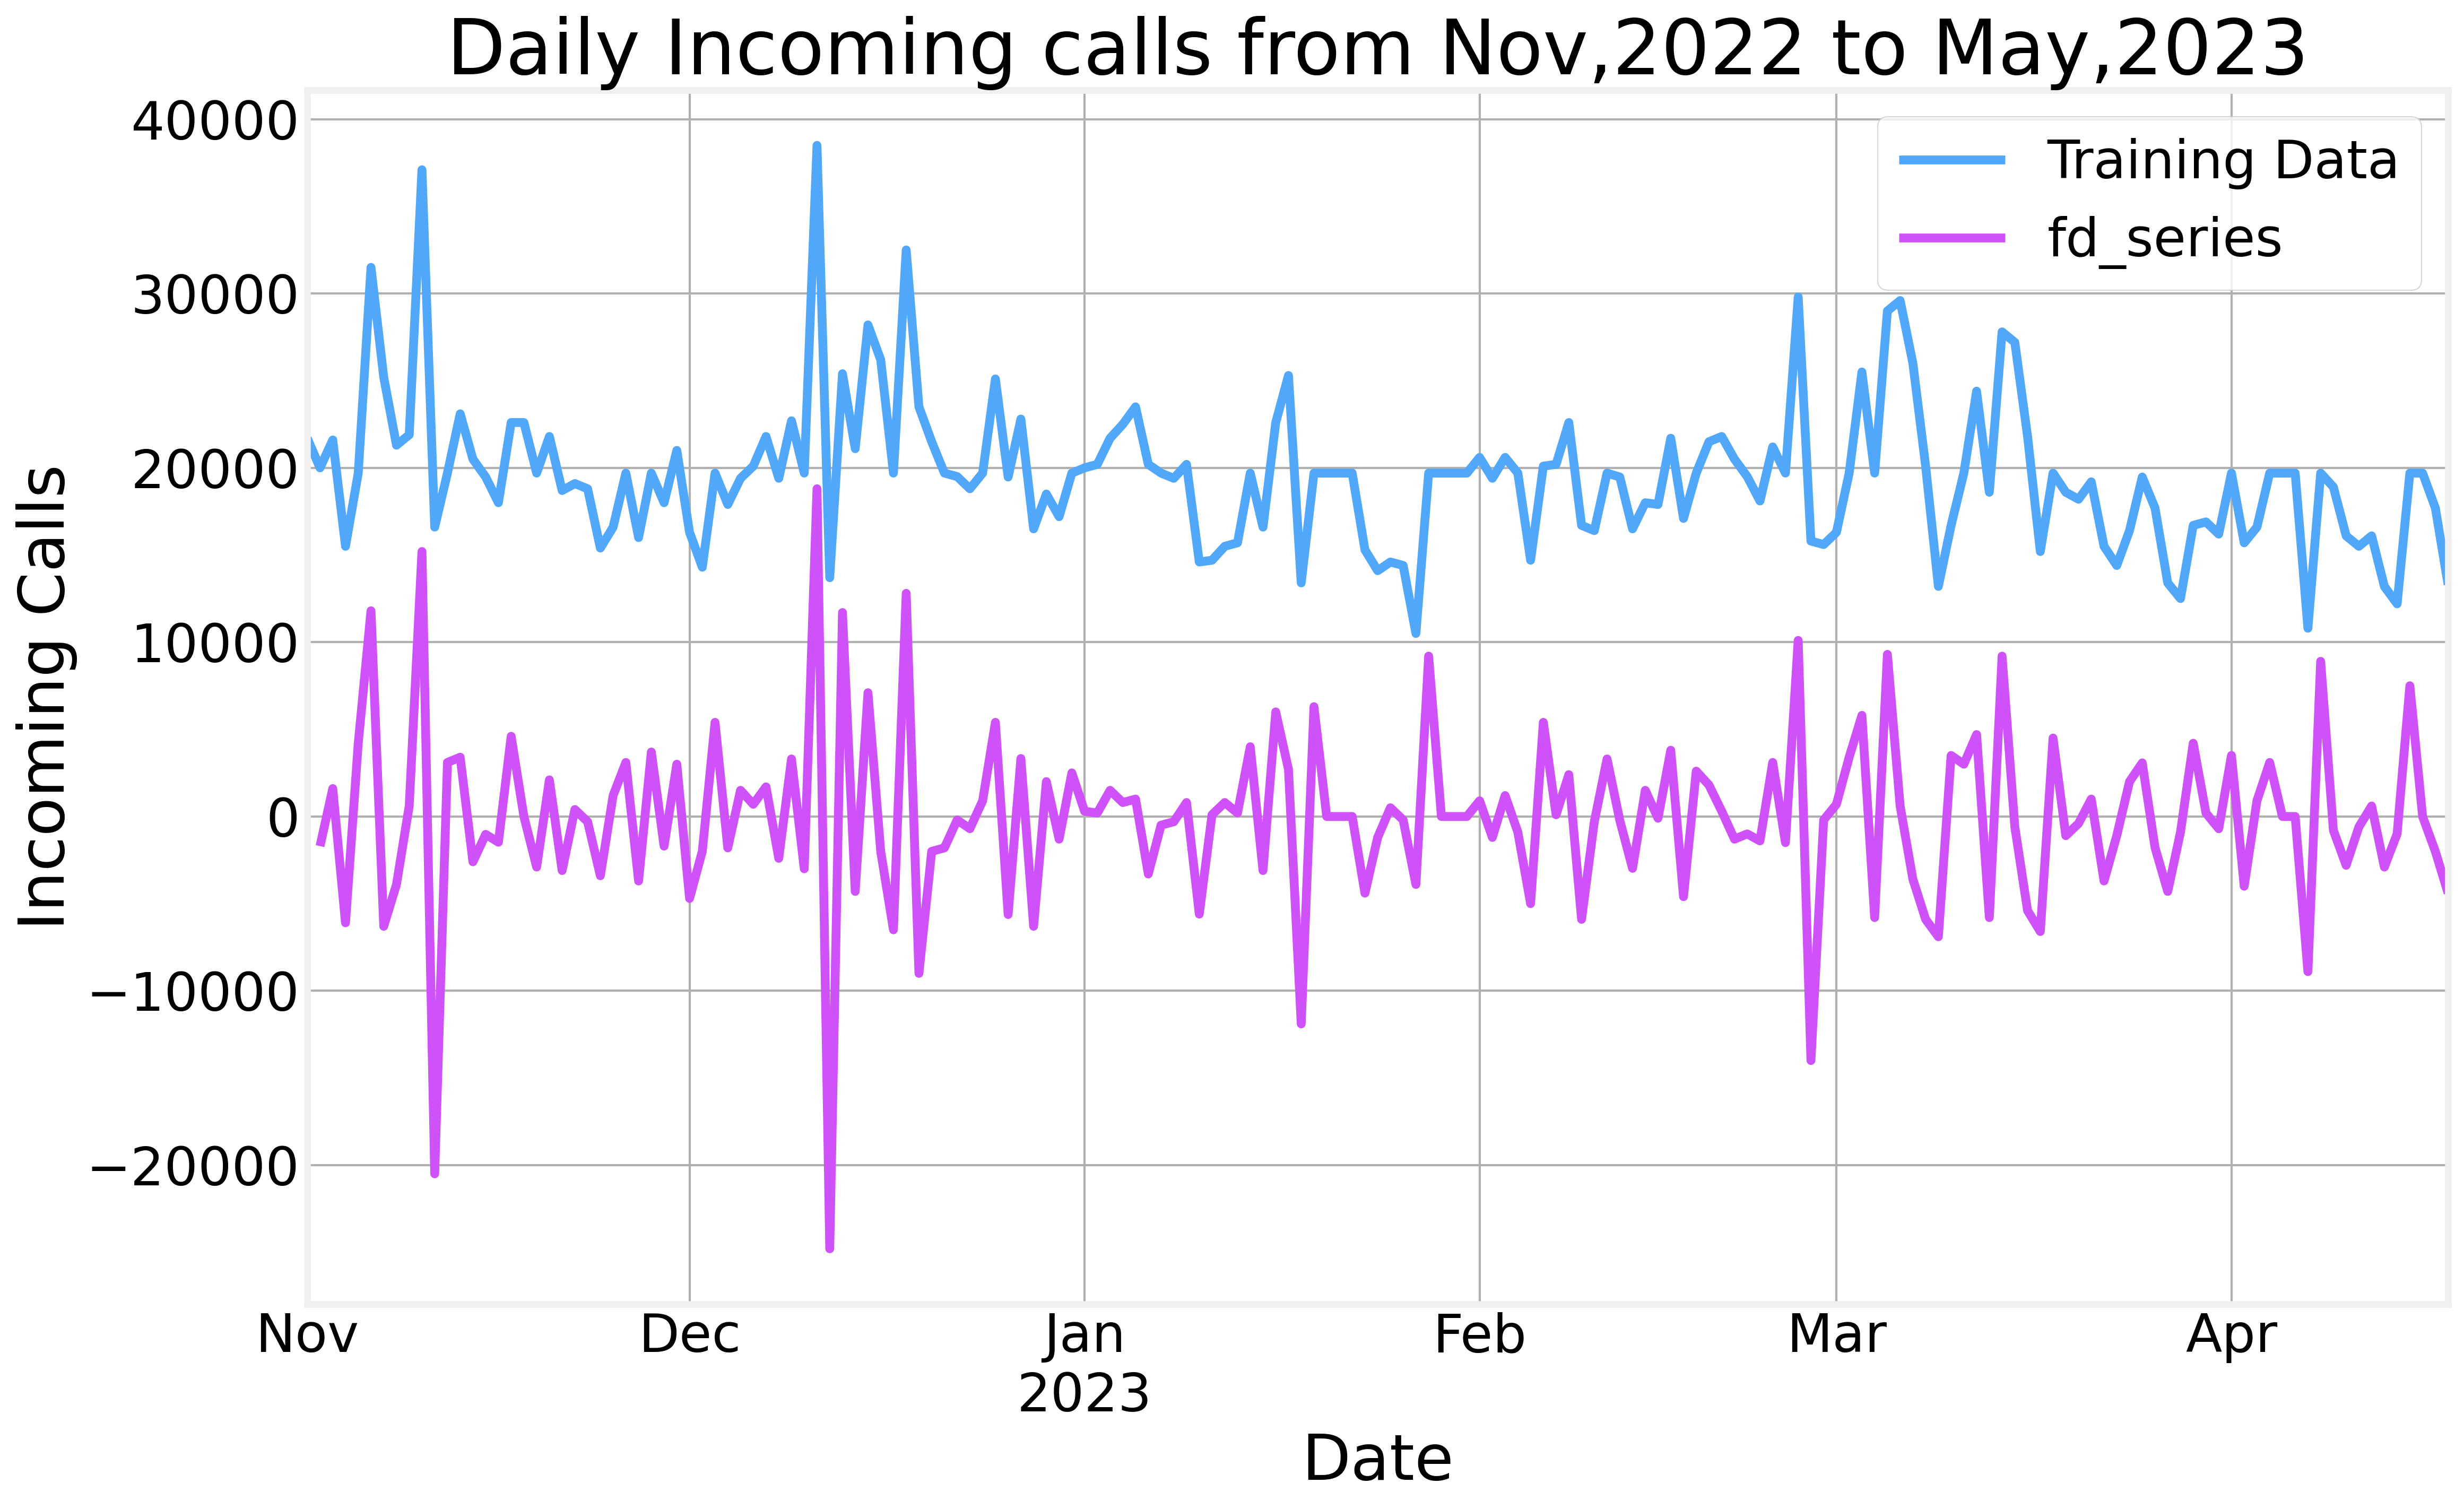

In [ ]:
plt.rcParams["figure.figsize"] = (16, 10)
train.plot(label='Training Data')
fd_series.plot(label='fd_series')
plt.title("Daily Incoming calls from Nov,2022 to May,2023")
plt.xlabel("Date")
plt.ylabel("Incoming Calls")
plt.legend()
plt.show()

Calling plot_act the fd series with lags=90

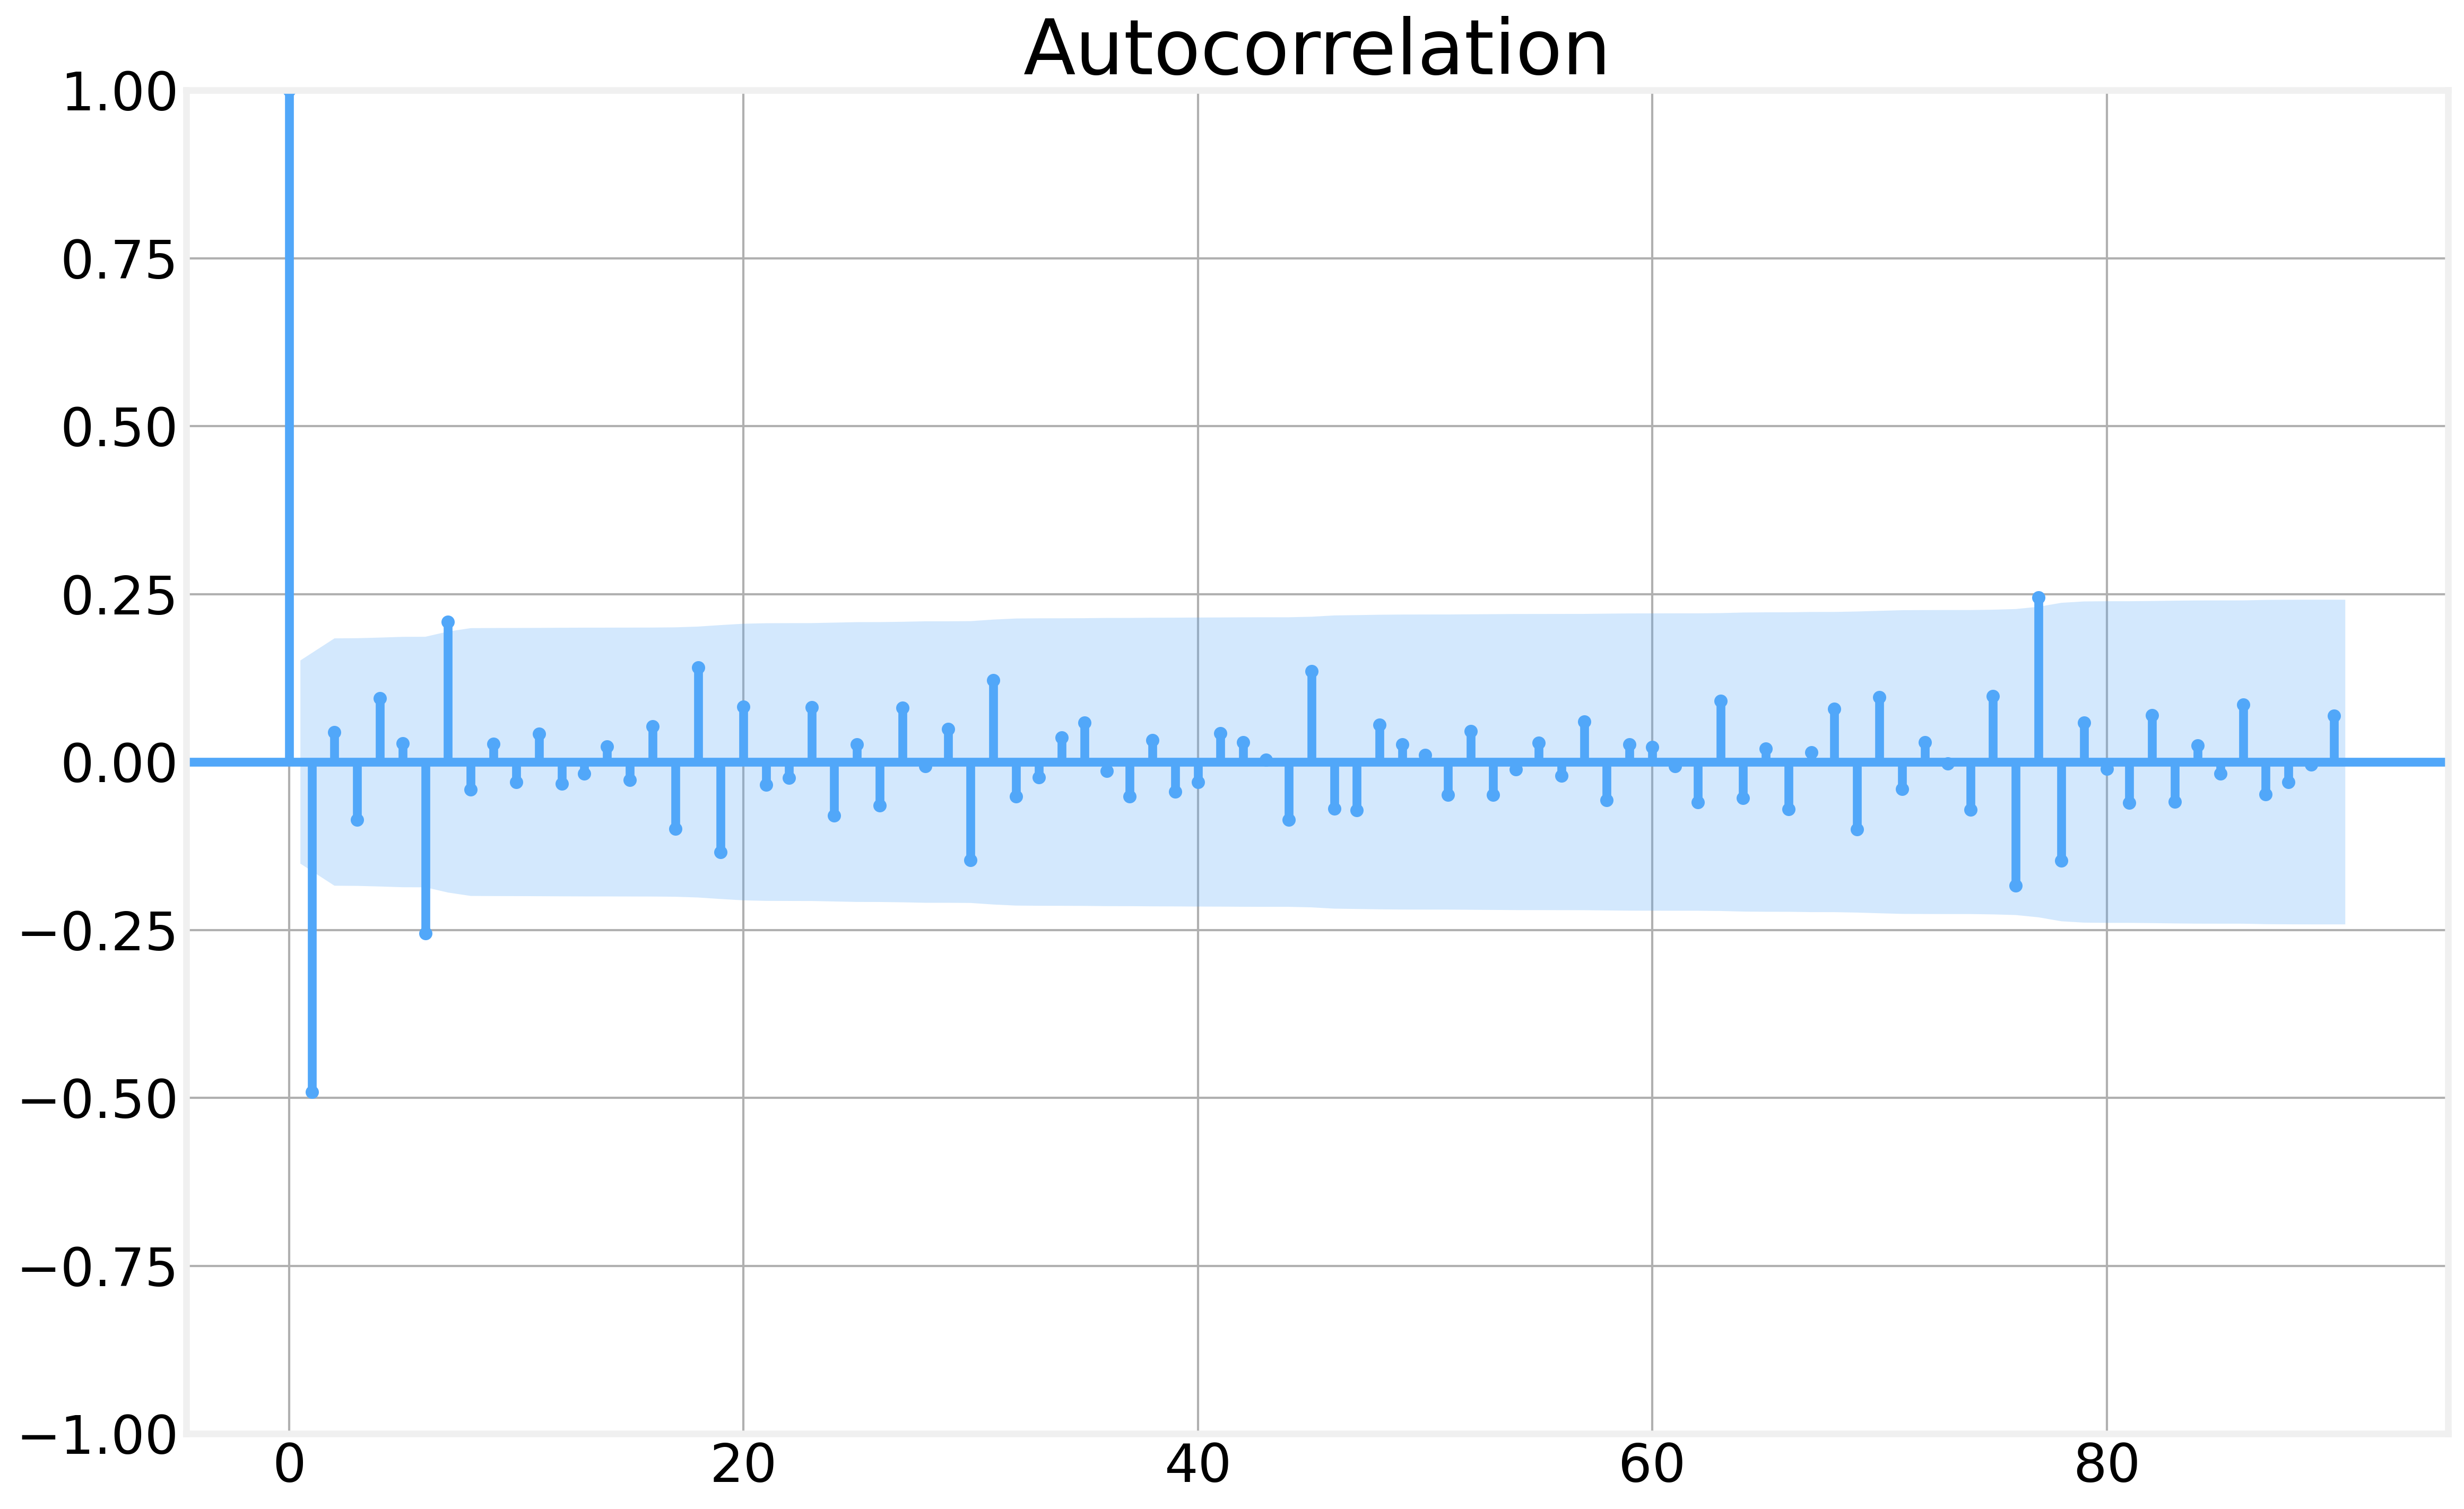

In [ ]:
plot_acf(fd_series, lags=90);

calling plot_ac the fd_series only

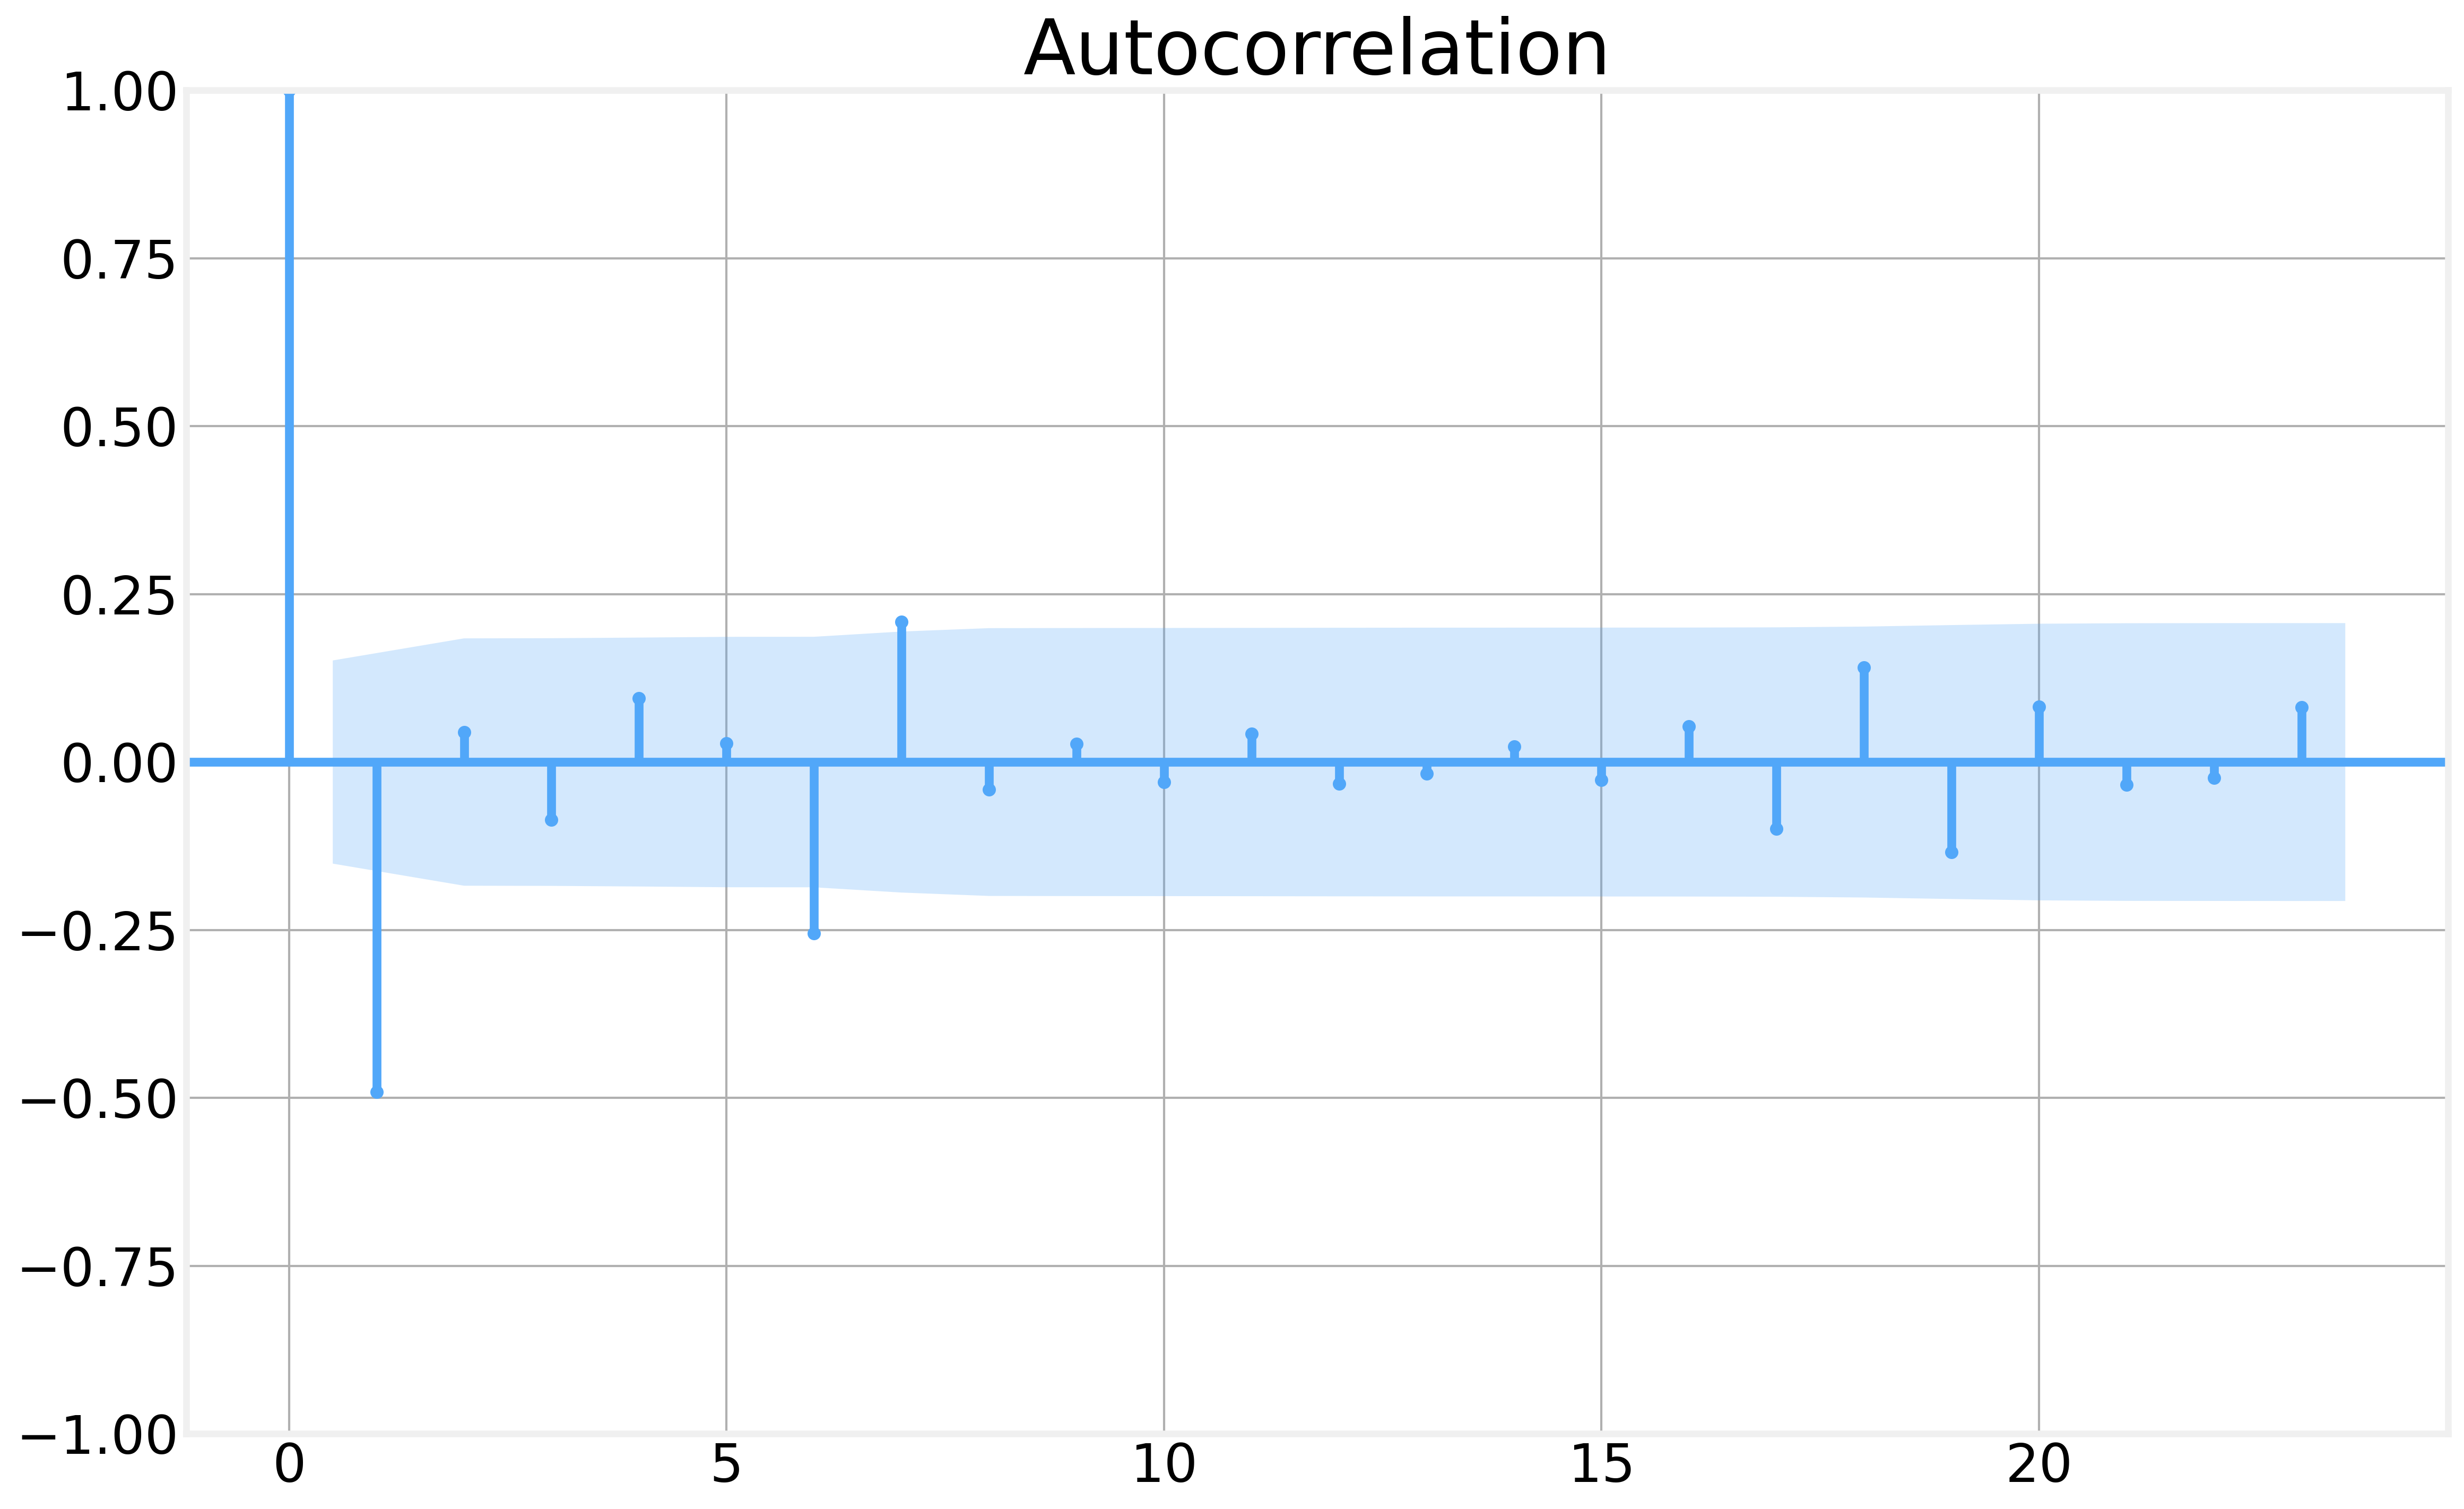

In [ ]:
plot_acf(fd_series);

Creating an ARIMA model using the train set and order (1,1,0). Will see the summary by calling summary method

In [ ]:
model = ARIMA(train, order=(1, 1, 0))
model_fit = model.fit()
model_fit.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         Incoming Calls   No. Observations:                  169
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1653.621
Date:                Wed, 14 Jun 2023   AIC                           3311.242
Time:                        14:19:29   BIC                           3317.490
Sample:                    11-01-2022   HQIC                          3313.777
                         - 04-18-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4564      0.042    -10.960      0.000      -0.538      -0.375
sigma2      2.047e+07   4.52e-10   4.53e+16      0.000    2.05e+07    2.05e+07
===================================================================================
Ljung-Box (L1) (Q):                   3.94   Jarque-Bera (JB):                43.69
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                             0.18
Prob(H) (two-sided):                  0.08   Kurtosis:                         5.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

For modeling purpose will create train an test with only the series values of train and test. Historical

In [ ]:
train=train.values
test=test.values

In [ ]:
historical_data = [temp for temp in train]
predictions=list()

Forecasting. Doing rolling forecast ARIMA model

In [ ]:
for t in range(len(test)):
	model = ARIMA(historical_data, order=(1,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	pred = output[0]
	predictions.append(pred)
	obs = test[t]
	historical_data.append(obs)
	print('predicted=%.2f, expected=%.2f' % (pred, obs))

predicted=15308.18, expected=19475.00
predicted=16633.89, expected=12700.00
predicted=15850.07, expected=14800.00
predicted=13826.52, expected=19700.00
predicted=17440.56, expected=14100.00
predicted=16700.31, expected=12400.00
predicted=13181.37, expected=16500.00
predicted=14610.96, expected=16800.00
predicted=16662.30, expected=19800.00
predicted=18423.52, expected=13900.00
predicted=16622.65, expected=19700.00
predicted=17003.10, expected=18400.00
predicted=19002.47, expected=20700.00
predicted=19633.08, expected=19100.00
predicted=19842.60, expected=21300.00
predicted=20277.91, expected=30000.00
predicted=25994.20, expected=30000.00
predicted=30000.00, expected=19700.00
predicted=24374.18, expected=27500.00
predicted=23913.81, expected=20500.00
predicted=23752.52, expected=19700.00
predicted=20067.60, expected=20000.00
predicted=19862.15, expected=15400.00
predicted=17514.85, expected=16300.00
predicted=15887.12, expected=19700.00
predicted=18142.34, expected=21800.00
predicted=20

Model Evaluation

Checking the RMSE

In [ ]:
rmse = sqrt(mean_squared_error(test, predictions))
print(rmse)
print('Test RMSE: %.2f' % rmse)

3513.753416256584
Test RMSE: 3513.75


In [ ]:
normRMSE=rmse/(test.max()-test.min())
normRMSE

0.19964508046912408

Ploting the forecasted values with test values

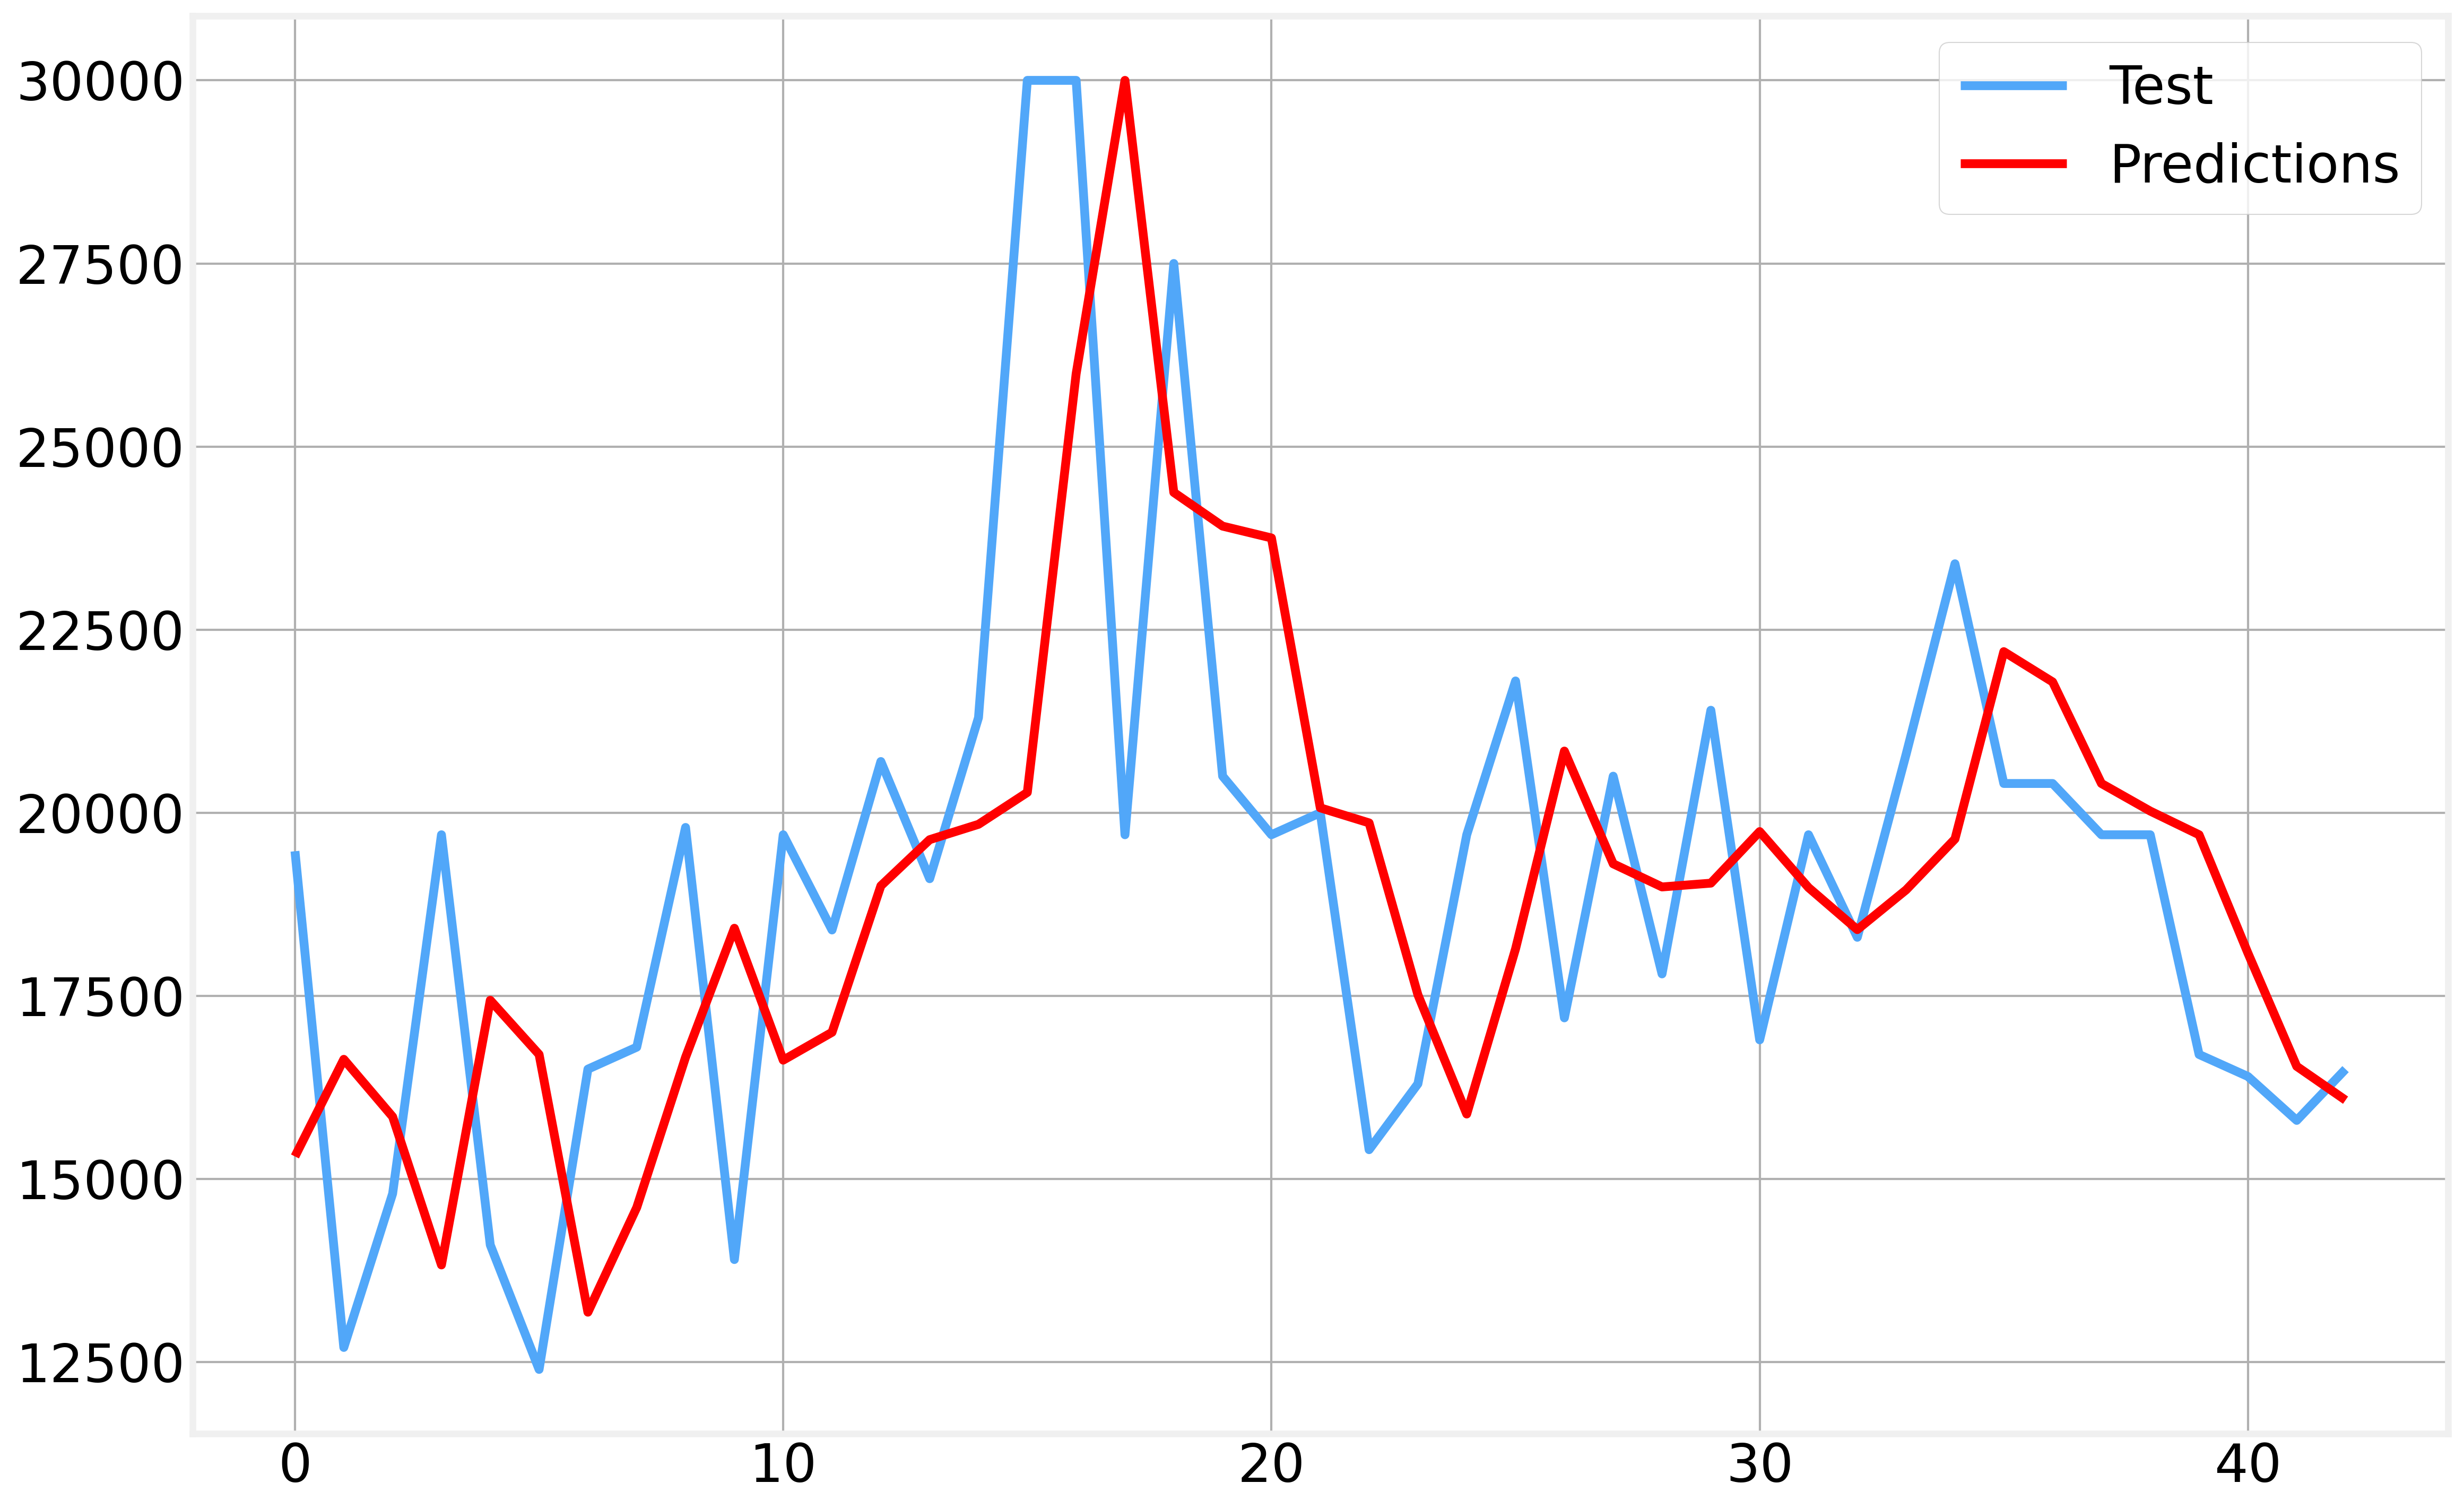

In [ ]:
plt.plot(test, label="Test")
plt.plot(predictions, color='red', label="Predictions")
plt.legend()
plt.show()

Forecasting Calls with the full dataset. Creating an object named model to store the ARIMA model an object named model_fit to store the fitted model and finally and object named forecast to store the forecasted data for the next 1 month.

In [ ]:
model = ARIMA(series, order=(2,1,2))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [ ]:
model_fit = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [ ]:
forecast = model_fit.forecast(steps=30)

Cheching the forecasted values

In [ ]:
forecast.head(5)

2023-06-01    17725.188096
2023-06-02    17988.368697
2023-06-03    18248.372118
2023-06-04    18451.450902
2023-06-05    18613.159457
Freq: D, Name: predicted_mean, dtype: float64

Ploting the forecasted values along with original data

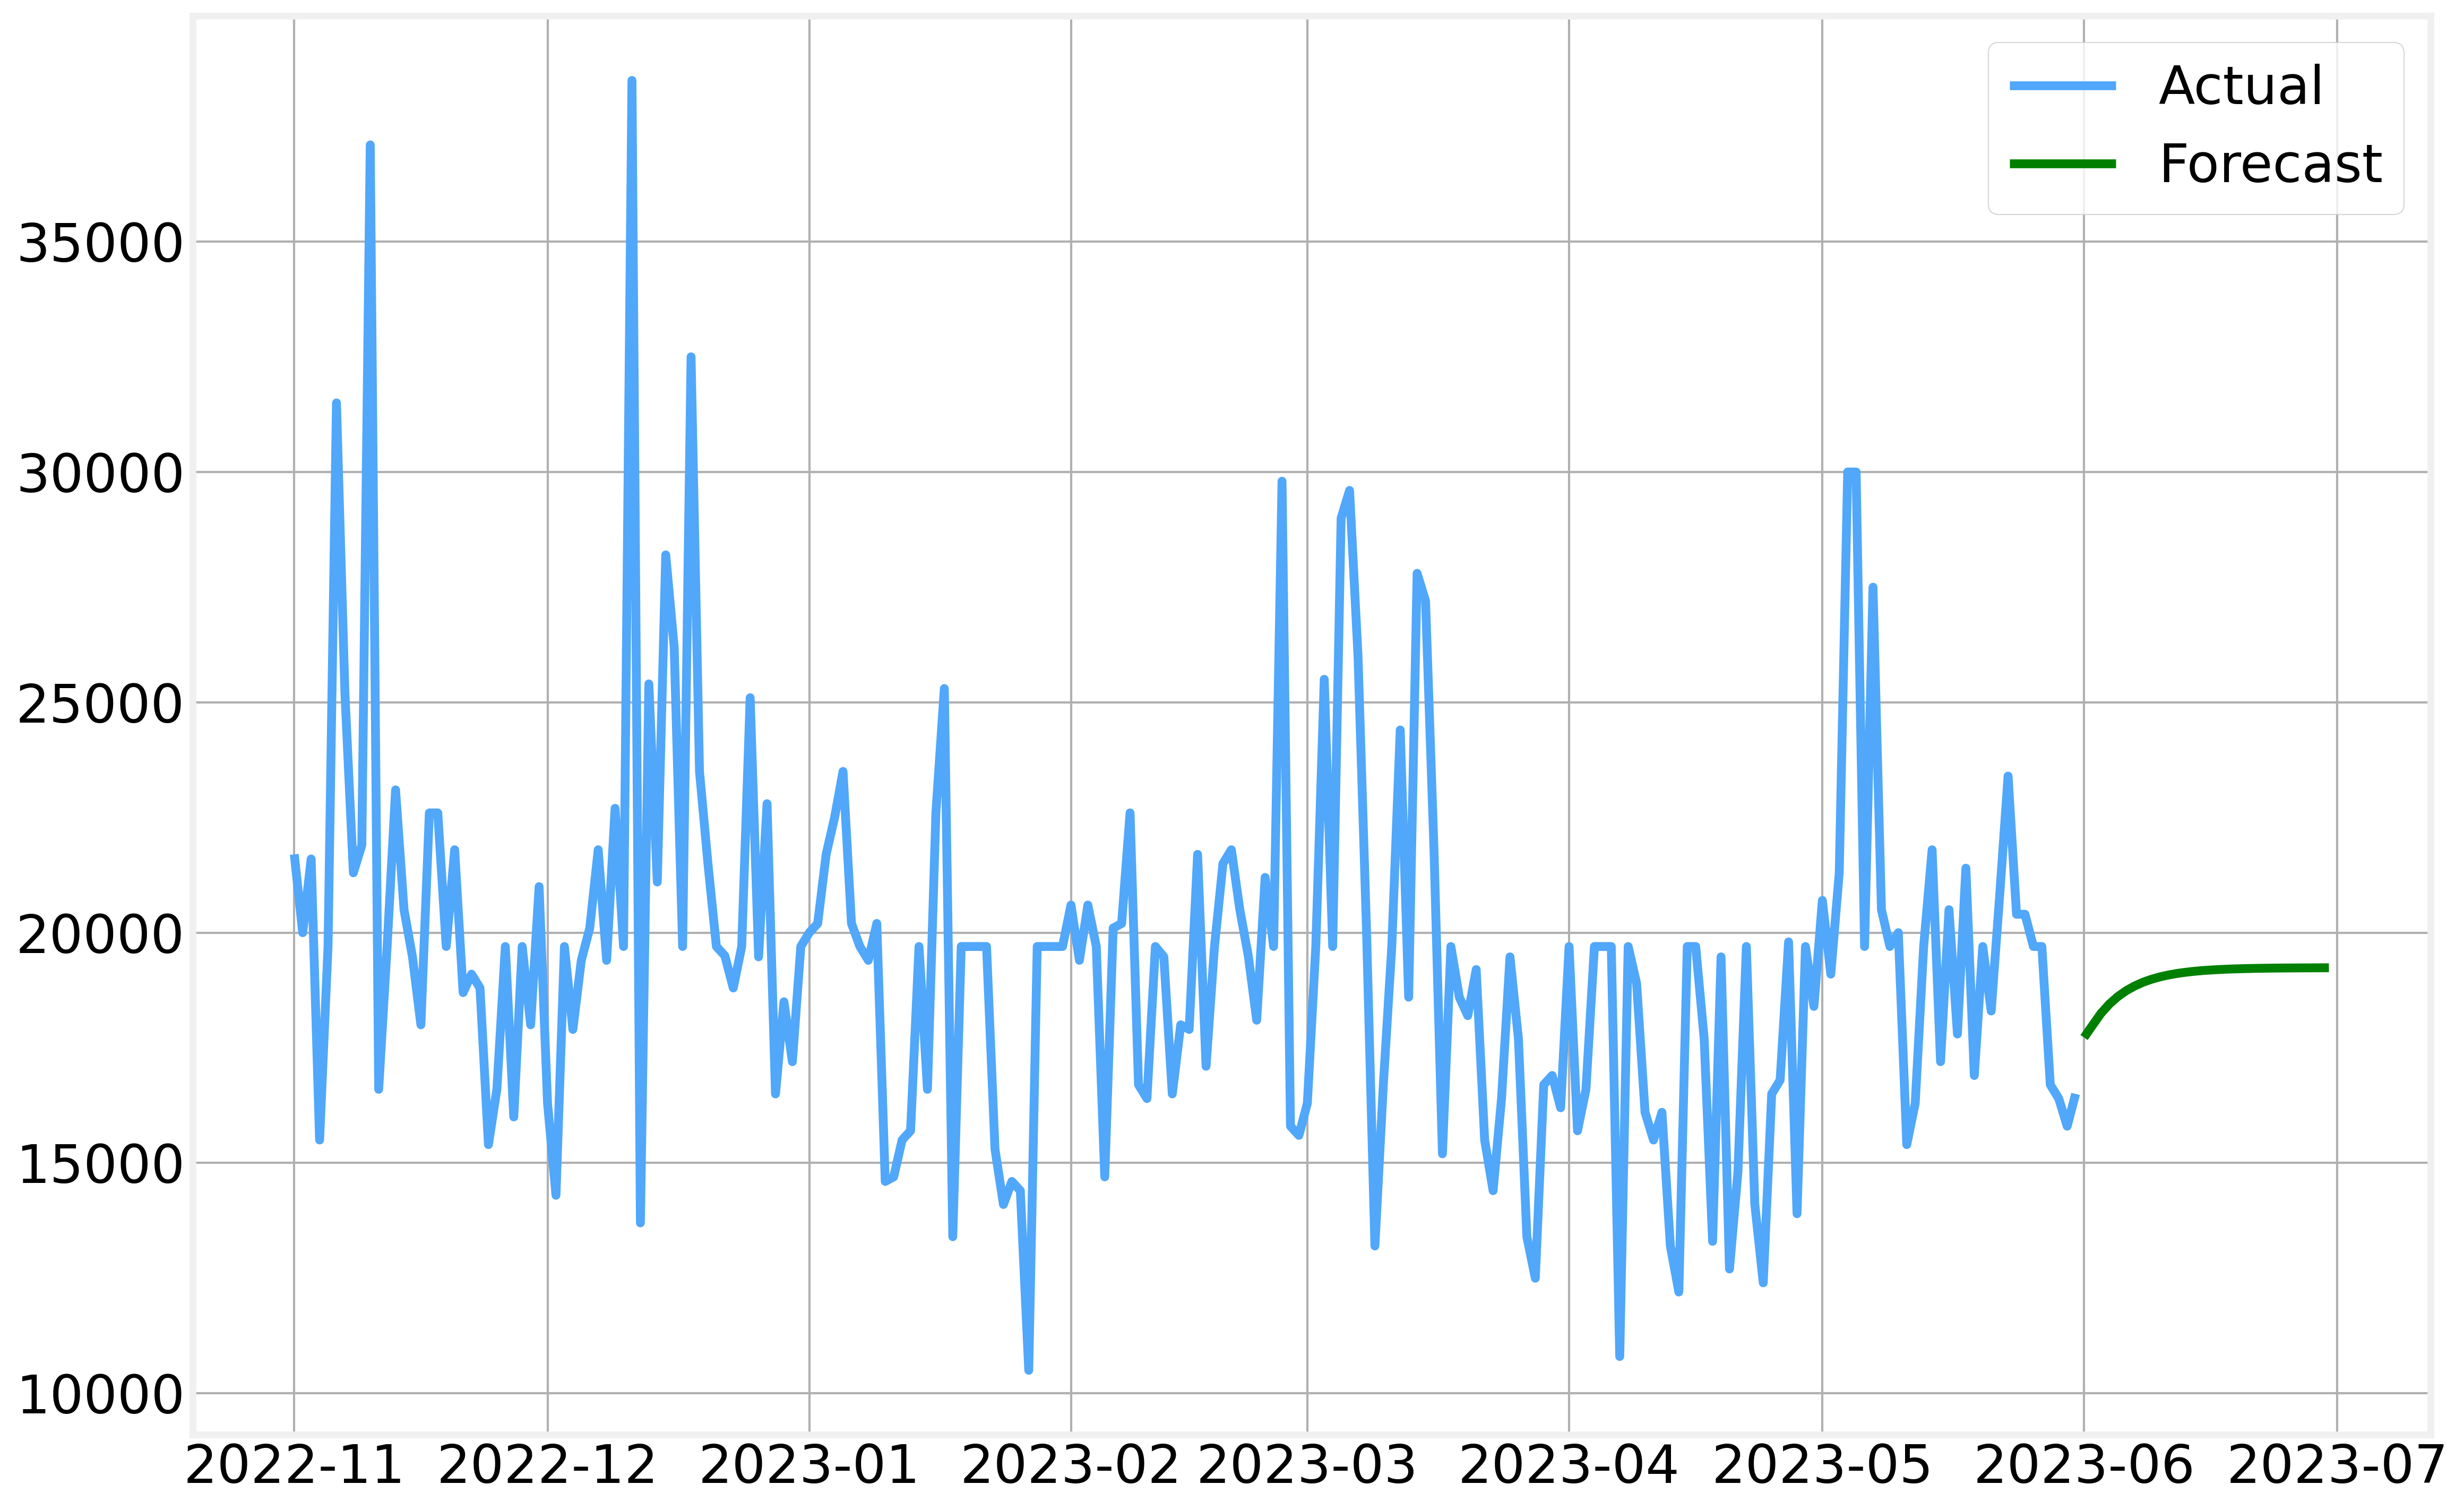

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
plt.plot(series, label="Actual")

plt.plot(forecast, color='green', label="Forecast")

plt.legend()
plt.show()

Exporting the forecasted values to a CSV file

In [ ]:
forecast.to_csv('forecasted_data.csv')